In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
import dask.array as da
warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

In [2]:
years = [1991, 2020]
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
# Model names
nl = dict(zip( ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2', 'CanESM5', 'GEM5.2-NEMO', 'GEM5-NEMO', 'CanCM4i-IC3',],
               [       11,                 11,         11,           11,              8,            9,        11,            11,          11,            11,])) # Max lead time for each model

In [3]:
is_detrend=True
il=10
mods = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']#

In [4]:
def BSSpath(mods,is_detrend,years,il):
    basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
    # Input/output directory
    mhwdir = basepath+'/mhw/detrended' if is_detrend else basepath+'/mhw'
    if is_detrend:
        f_save = f'{mhwdir}/BSS_MME_{"_".join(mods)}_l{il}_detrended_{years[0]}_{years[1]}.nc'
    else:
        f_save = f'{mhwdir}/BSS_MME_{"_".join(mods)}_l{il}_{years[0]}_{years[1]}.nc'
    return f_save

In [5]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
# Input/output directory
if is_detrend:
    mhwdir = basepath+'/mhw/detrended';
    f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
else:
    mhwdir = basepath+'/mhw';
    f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
fobs=xr.open_dataset(f_obs)
    
# Loop through models
is_mhw_ens=[]
mlist=[]
flist=[]
for modi in mods:
    if il<nl[modi]:
        # Load MHWs
        if is_detrend:
            f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{years[0]}_{years[1]}.nc'
        else:
            f_in = f'{mhwdir}/mhw_{modi}_l{il}_{years[0]}_{years[1]}.nc'
        flist.append(f_in)
ffor=xr.open_mfdataset(flist,chunks={'X':10,'Y':10,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                   coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]) )

M0=xr.where(np.isnan(ffor.is_mhw),0,1).sum(dim='M').mean(dim='S')

In [6]:
# calculate Briar Skill Score
Ms=np.unique(M0)
if len(Ms)>1: raise Exception('check M')
M=Ms[0]
mhwfor=ffor.is_mhw.mean(dim='M').data[:(-1*il),...]
mhwobs=fobs.is_mhw.data[il:,...]

In [7]:
print('nt:',mhwobs.shape[0])

nt: 350


In [8]:
BrS=da.sum((mhwfor-mhwobs)**2,axis=0)/mhwobs.shape[0]
BrS

dask.array<truediv, shape=(181, 360), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>

In [9]:
BrSref=da.sum((0.1-mhwobs)**2,axis=0)/mhwobs.shape[0]

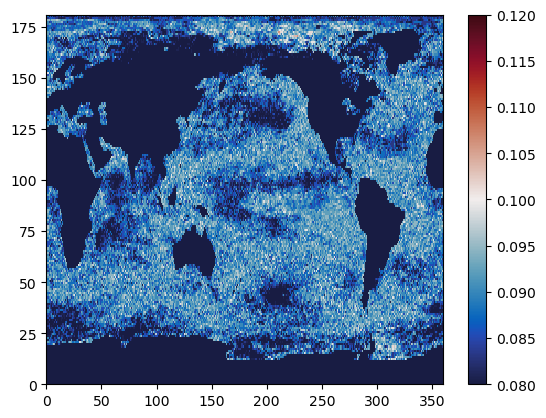

In [19]:
plt.pcolormesh(np.ma.masked_where(BrSref==0,BrSref),vmin=.08,vmax=.12,cmap=cmocean.cm.balance)
plt.colorbar()

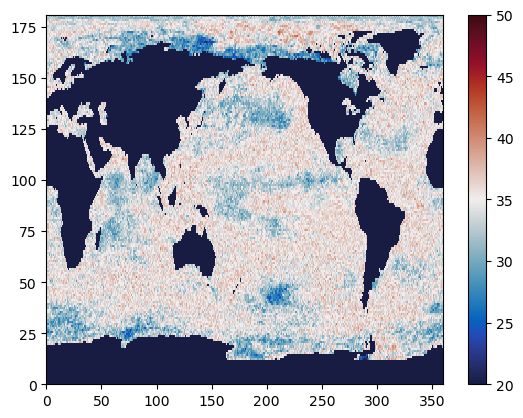

In [18]:
# Why is this not more constant?
plt.pcolormesh(da.sum(mhwobs,axis=0),vmin=20,vmax=50,cmap=cmocean.cm.balance)
plt.colorbar()

In [ ]:
print('nt:',mhwobs.shape[0])
BrS=da.sum((mhwfor-mhwobs)**2,axis=0)/mhwobs.shape[0]
BSS=1-BrS/


N_pos=np.sum(mhwfor,axis=1).compute()
N_neg=np.sum((mhwfor==0).astype(float),axis=1).compute()
TP=np.where(mhwobs==1,N_pos,0)
TN=np.where(mhwobs==0,N_neg,0)
FP=np.where(mhwobs==0,N_pos,0)
FN=np.where(mhwobs==1,N_neg,0)


Nobs_pos=np.sum(mhwobs,axis=0)
Nobs_neg=np.sum(1-mhwobs,axis=0)
F=np.sum(FP,axis=0)/(Nobs_neg*M)
H=np.sum(TP,axis=0)/(Nobs_pos*M)

SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
lmask=np.logical_or(np.sum(fobs.is_mhw.data,axis=0)==0,M0.data==0)

f_save=SEDIpath(mods,is_detrend,years,il)
if save:
    xout=xr.Dataset(data_vars={'lon':(['X',],ffor.lon.values),
                'lat':(['Y',],ffor.lat.values),
                'SEDI':(['Y','X'],np.ma.masked_where(lmask,SEDI))},
                coords=dict(X=ffor.X,Y=ffor.Y),)
    xout.to_netcdf(f_save,mode='w')
ffor.close()
return

In [ ]:
def calcBSS_il(mods,is_detrend,years,il,save=True):
    basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
    # Input/output directory
    if is_detrend:
        mhwdir = basepath+'/mhw/detrended';
        f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    else:
        mhwdir = basepath+'/mhw';
        f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    fobs=xr.open_dataset(f_obs)
        
    # Loop through models
    is_mhw_ens=[]
    mlist=[]
    flist=[]
    for modi in mods:
        if il<nl[modi]:
            # Load MHWs
            if is_detrend:
                f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{years[0]}_{years[1]}.nc'
            else:
                f_in = f'{mhwdir}/mhw_{modi}_l{il}_{years[0]}_{years[1]}.nc'
            flist.append(f_in)
    ffor=xr.open_mfdataset(flist,chunks={'X':10,'Y':10,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                       coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]) )

    M0=xr.where(np.isnan(ffor.is_mhw),0,1).sum(dim='M').mean(dim='S')
    
    # calculate Brier Skill Score
    Ms=np.unique(M0)
    if len(Ms)>1: raise Exception('check M')
    M=Ms[0]
    mhwfor=ffor.is_mhw.mean(dim='M').data[:(-1*il),...]
    mhwobs=fobs.is_mhw.data[il:,...]
    print('nt:',mhwobs.shape[0])
    BrS=da.sum((mhwfor-mhwobs)**2,axis=0)/mhwobs.shape[0]
    BrSref=da.sum((.1-mhwobs)**2,axis=0)/mhwobs.shape[0]
    BSS=1-BrS/BrSref

    lmask=np.logical_or(np.sum(fobs.is_mhw.data,axis=0)==0,M0.data==0)

    f_save=BSSpath(mods,is_detrend,years,il)
    if save:
        xout=xr.Dataset(data_vars={'lon':(['X',],ffor.lon.values),
                    'lat':(['Y',],ffor.lat.values),
                    'BrS':(['Y','X'],np.ma.masked_where(lmask,BrS)),
                    'BrSref':(['Y','X'],np.ma.masked_where(lmask,BrSref)),
                    'BSS':(['Y','X'],np.ma.masked_where(lmask,BSS))},
                    coords=dict(X=ffor.X,Y=ffor.Y),)
        xout.to_netcdf(f_save,mode='w')
    ffor.close()
    return

In [ ]:
for is_detrend in (True,False):
    print('is_detrend:',is_detrend)
    for il in (1,3,6,10):
        print(' il:',il)
        fSEDI=SEDIpath(mods,is_detrend,years,il)
        print(fSEDI)
        if not os.path.exists(fSEDI):
            calcSEDI_il(mods,is_detrend,years,il)
print('done')